# Assignment 4
Halka Hanna


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from statsmodels.tsa.seasonal import MSTL

### helper function

Function which visualize splitting into train and val.

In [2]:
def visualize_split(df, data, title):
    train = df.loc[df.index < data]
    val = df.loc[df.index >= data]

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title=title, color='#3A92E4')
    val.plot(ax=ax, label='Val Set', color='#3AE48C')
    ax.axvline(data, color='black', ls='--')
    ax.legend(['Training Set', 'Val Set'])
    plt.show()
    return train, val

In [3]:
def calculate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return rmse, mae, mape

## Daily Temperature

In [4]:
df_tempt = pd.read_csv('../data/daily_tempt.csv')
df_tempt['data_ind'] = df_tempt['Date']
df_tempt = df_tempt.set_index('data_ind')
df_tempt.index = pd.to_datetime(df_tempt.index)

STL decomposition complete.


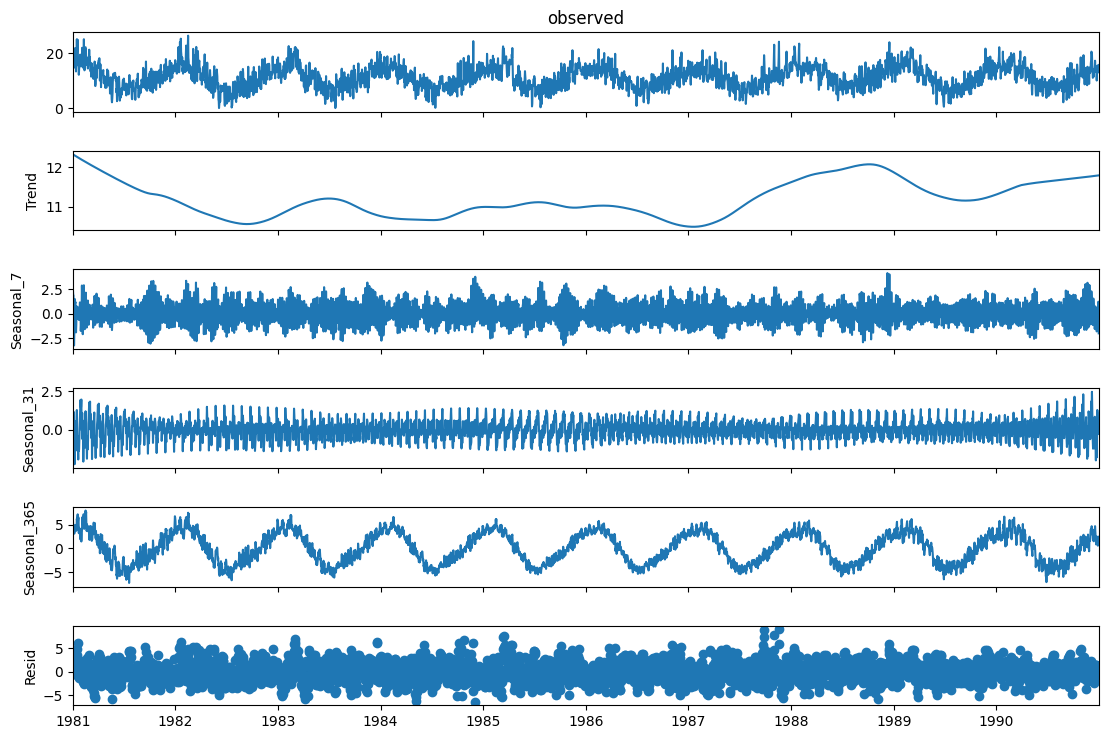

In [5]:
stl_tempt = MSTL(df_tempt['mean-tempt'], periods=[7, 31, 365], windows=[7, 31, 365])
res_stl = stl_tempt.fit()

decomposed_df = df_tempt.copy()
decomposed_df['trend'] = res_stl.trend
decomposed_df['seasonal_7'] = res_stl.seasonal['seasonal_7']
decomposed_df['seasonal_31'] = res_stl.seasonal['seasonal_31']
decomposed_df['seasonal_365'] = res_stl.seasonal['seasonal_365']
decomposed_df['resid'] = res_stl.resid
decomposed_df['y_adjusted'] = decomposed_df['trend'] + decomposed_df['resid']

print("STL decomposition complete.")

fig = res_stl.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
plt.show()

In [6]:
temp_decomposed = (
    decomposed_df[['Date', 'seasonal_7', 'seasonal_31', 'seasonal_365', 'resid', 'y_adjusted']]
    .assign(unique_id='mean-temp')
    .rename(columns={
        'Date': 'ds',
        'y_adjusted': 'y'
    })
)

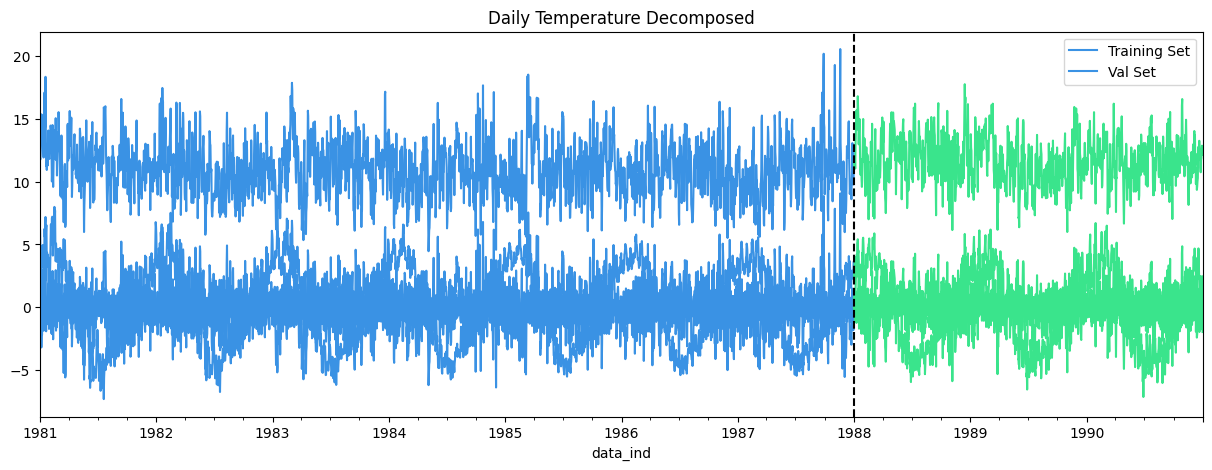

In [7]:
train_tempt, val_tempt = visualize_split(temp_decomposed, '1988-01-01', 'Daily Temperature Decomposed')

### Decomposition-Based Forecasting

Prediction of seasonal component.

In [8]:
forecast_horizon = len(val_tempt)

sf_seasonal_7 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D')
sf_seasonal_7.fit(train_tempt[['ds', 'unique_id', 'seasonal_7']].rename(columns={'seasonal_7': 'y'}))
fcst_seasonal_7_df = sf_seasonal_7.predict(h=forecast_horizon)

sf_seasonal_31 = StatsForecast(models=[SeasonalNaive(season_length=31)], freq='D')
sf_seasonal_31.fit(train_tempt[['ds', 'unique_id', 'seasonal_31']].rename(columns={'seasonal_31': 'y'}))
fcst_seasonal_31_df = sf_seasonal_31.predict(h=forecast_horizon)

sf_seasonal_365 = StatsForecast(models=[SeasonalNaive(season_length=365)], freq='D')
sf_seasonal_365.fit(train_tempt[['ds', 'unique_id', 'seasonal_365']].rename(columns={'seasonal_365': 'y'}))
fcst_seasonal_365_df = sf_seasonal_365.predict(h=forecast_horizon)

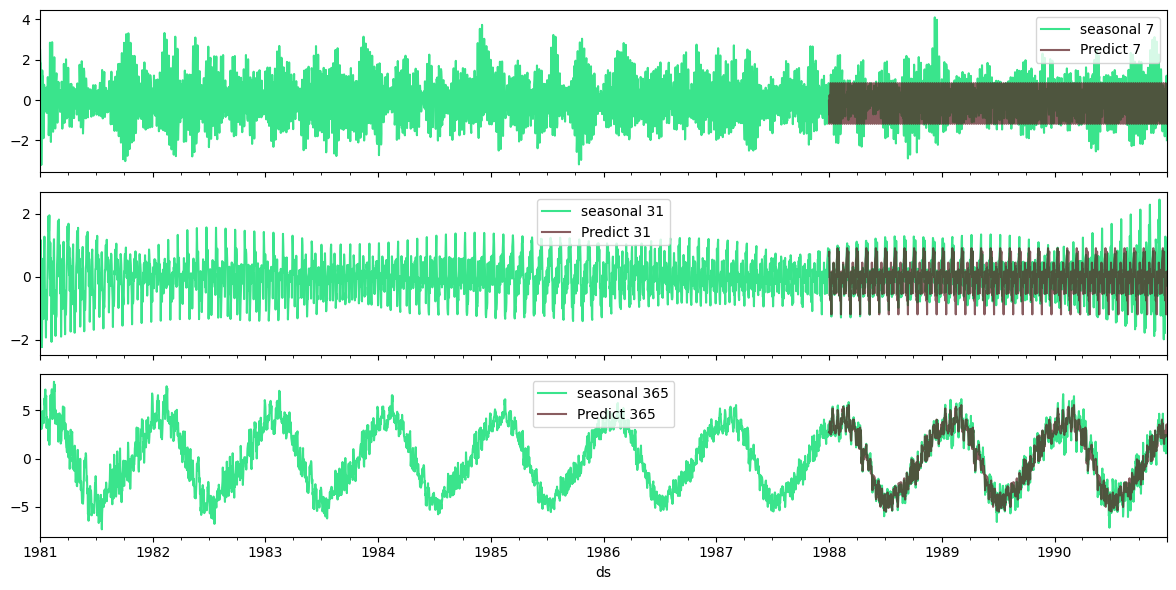

In [9]:
fig, (ax_seasonal_7, ax_seasonal_31, ax_seasonal_365) = plt.subplots(
    3, 1, figsize=(12, 6), sharex=True
)

fcst_7 = fcst_seasonal_7_df.set_index('ds')['SeasonalNaive']
fcst_31 = fcst_seasonal_31_df.set_index('ds')['SeasonalNaive']
fcst_365 = fcst_seasonal_365_df.set_index('ds')['SeasonalNaive']
seasonal_7 = decomposed_df['seasonal_7']
seasonal_31 = decomposed_df['seasonal_31']
seasonal_365 = decomposed_df['seasonal_365']

seasonal_7.plot(ax=ax_seasonal_7, label='seasonal 7', color='#3AE48C')
fcst_7.plot(ax=ax_seasonal_7, label='Predict 7', color='#57191D', alpha=0.7)
ax_seasonal_7.legend()

seasonal_31.plot(ax=ax_seasonal_31, label='seasonal 31', color='#3AE48C')
fcst_31.plot(ax=ax_seasonal_31, label='Predict 31', color='#57191D', alpha=0.7)
ax_seasonal_31.legend()

seasonal_365.plot(ax=ax_seasonal_365, label='seasonal 365', color='#3AE48C')
fcst_365.plot(ax=ax_seasonal_365, label='Predict 365', color='#57191D', alpha=0.7)
ax_seasonal_365.legend()

plt.tight_layout()
plt.show()

In [10]:
temp7_rmse, temp7_mae, temp7_mape = calculate(val_tempt['seasonal_7'],   fcst_7)
temp31_rmse, temp31_mae, temp31_mape = calculate(val_tempt['seasonal_31'], fcst_31)
temp365_rmse, temp365_mae, temp365_mape = calculate(val_tempt['seasonal_365'], fcst_365)

df = pd.DataFrame({
    'model': ['Seasonal 7', 'Seasonal 31', 'Seasonal 365'],
    'rmse':  [temp7_rmse,  temp31_rmse,   temp365_rmse],
    'mae':   [temp7_mae,   temp31_mae,    temp365_mae],
    'mape':  [temp7_mape,  temp31_mape,   temp365_mape],
}).set_index('model')

df

,rmse,mae,mape
model,,,
Seasonal 7,1.097965,0.883646,4456.554084
Seasonal 31,0.624270,0.441416,450.474778
Seasonal 365,0.570816,0.423729,53.324711


In [11]:
df.to_csv("../metrics/metrics_tempt.csv", index=True)

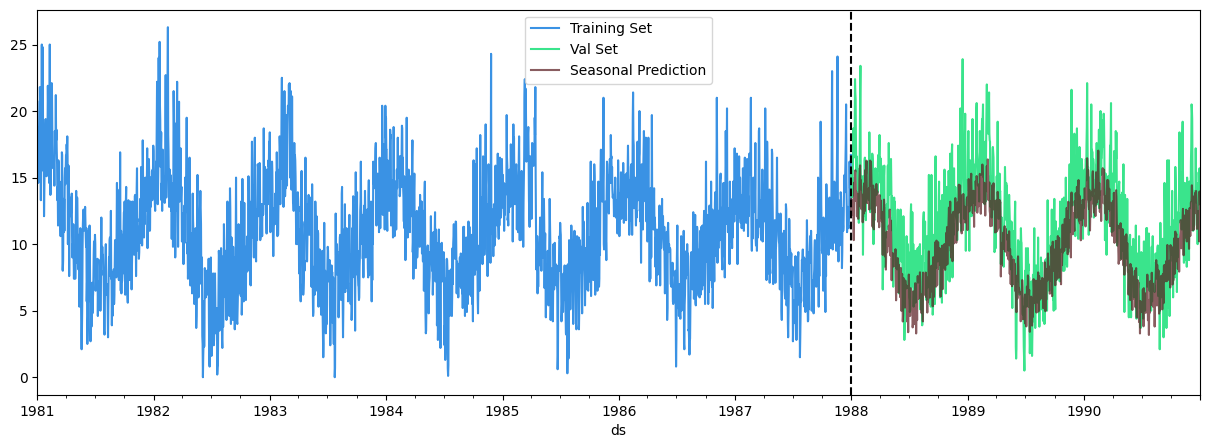

<Figure size 640x480 with 0 Axes>

In [12]:
seasonal_combo = (fcst_7 + fcst_31 + fcst_365) + 10

train = df_tempt.loc[df_tempt.index < '1988-01-01']
val = df_tempt.loc[df_tempt.index >= '1988-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title="", color='#3A92E4')
val.plot(ax=ax, label='Val Set', color='#3AE48C')
seasonal_combo.plot(ax=ax, label='Seasonal Prediction', color='#57191D', alpha=0.7)
ax.axvline('1988-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Val Set', 'Seasonal Prediction'])
plt.show()

plt.tight_layout()
plt.show()

## Weekly CO2

In [13]:
df_co2 = pd.read_csv('../data/weekly_co2.csv')
df_co2 = df_co2[['Date', 'average']] # We remove the column that we will not use
df_co2['data_ind'] = df_co2['Date']
df_co2 = df_co2.set_index('data_ind')
df_co2.index = pd.to_datetime(df_co2.index)

STL decomposition complete.


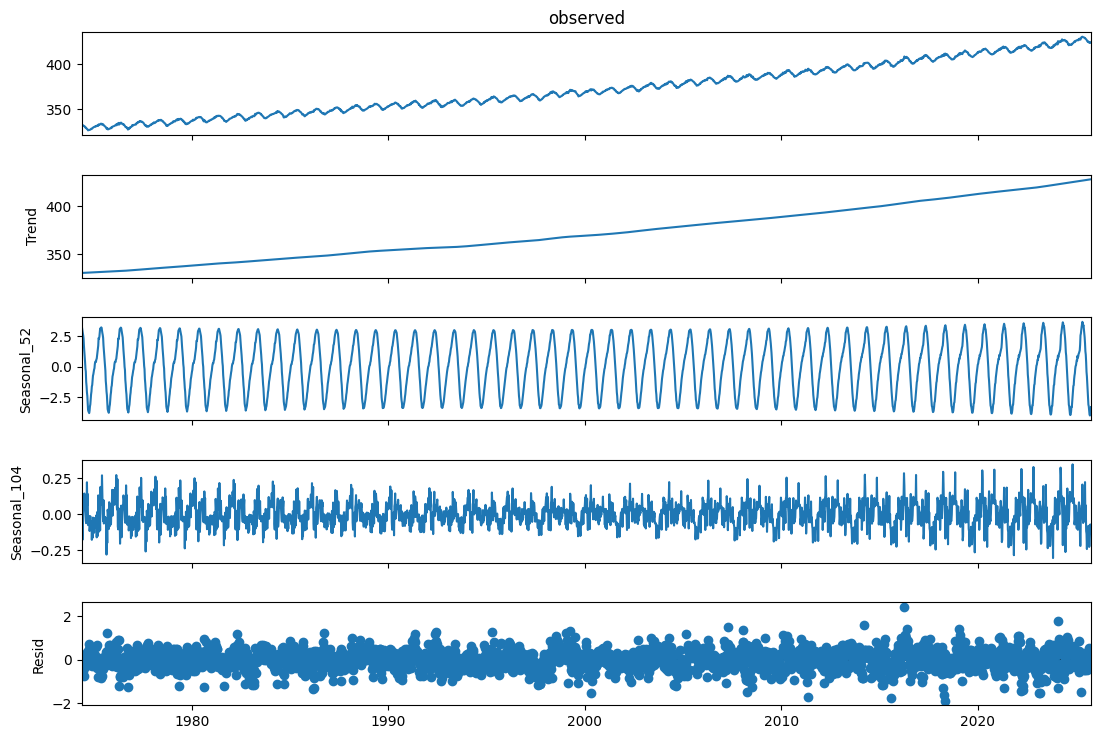

In [14]:
stl_co2 = MSTL(df_co2['average'], periods=[52, 104], windows=[53, 105])
res_stl = stl_co2.fit()

decomposed_df = df_co2.copy()
decomposed_df['trend'] = res_stl.trend
decomposed_df['seasonal_52'] = res_stl.seasonal['seasonal_52']
decomposed_df['seasonal_104'] = res_stl.seasonal['seasonal_104']
decomposed_df['resid'] = res_stl.resid
decomposed_df['y_adjusted'] = decomposed_df['trend'] + decomposed_df['resid']

print("STL decomposition complete.")

fig = res_stl.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
plt.show()

In [15]:
co2_decomposed = (
    decomposed_df[['Date', 'seasonal_52', 'seasonal_104', 'resid', 'y_adjusted']]
    .assign(unique_id='average')
    .rename(columns={
        'Date': 'ds',
        'y_adjusted': 'y'
    })
)

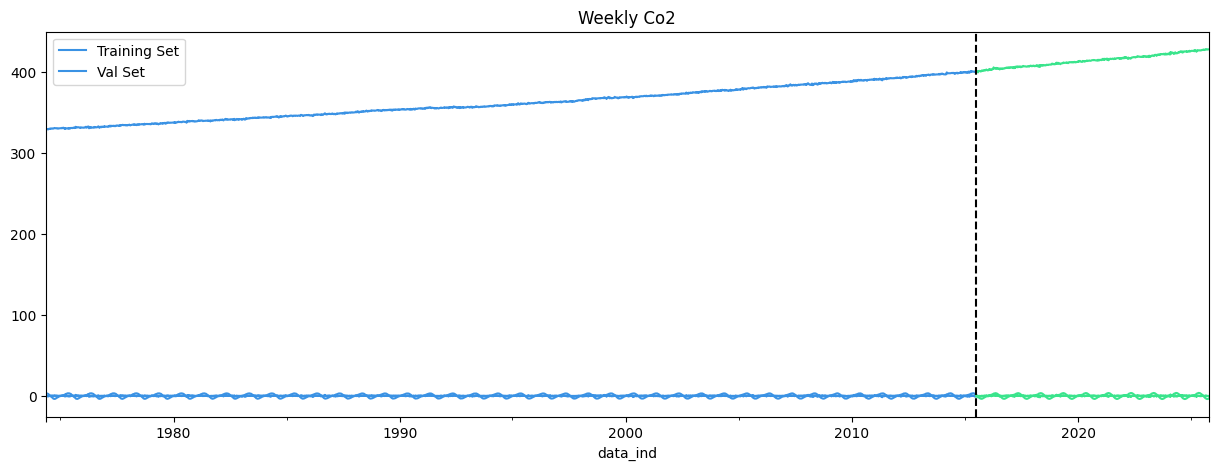

In [16]:
train_co2, val_co2 = visualize_split(co2_decomposed, '2015-07-05', 'Weekly Co2')

###  Decomposition-Based Forecasting

Prediction of seasonal component.

In [17]:
forecast_horizon = len(val_co2)

sf_seasonal_52 = StatsForecast(models=[SeasonalNaive(season_length=52)], freq='W')
sf_seasonal_52.fit(train_co2[['ds', 'unique_id', 'seasonal_52']].rename(columns={'seasonal_52': 'y'}))
fcst_seasonal_52_df = sf_seasonal_52.predict(h=forecast_horizon)

sf_seasonal_104 = StatsForecast(models=[SeasonalNaive(season_length=104)], freq='W')
sf_seasonal_104.fit(train_co2[['ds', 'unique_id', 'seasonal_104']].rename(columns={'seasonal_104': 'y'}))
fcst_seasonal_104_df = sf_seasonal_104.predict(h=forecast_horizon)

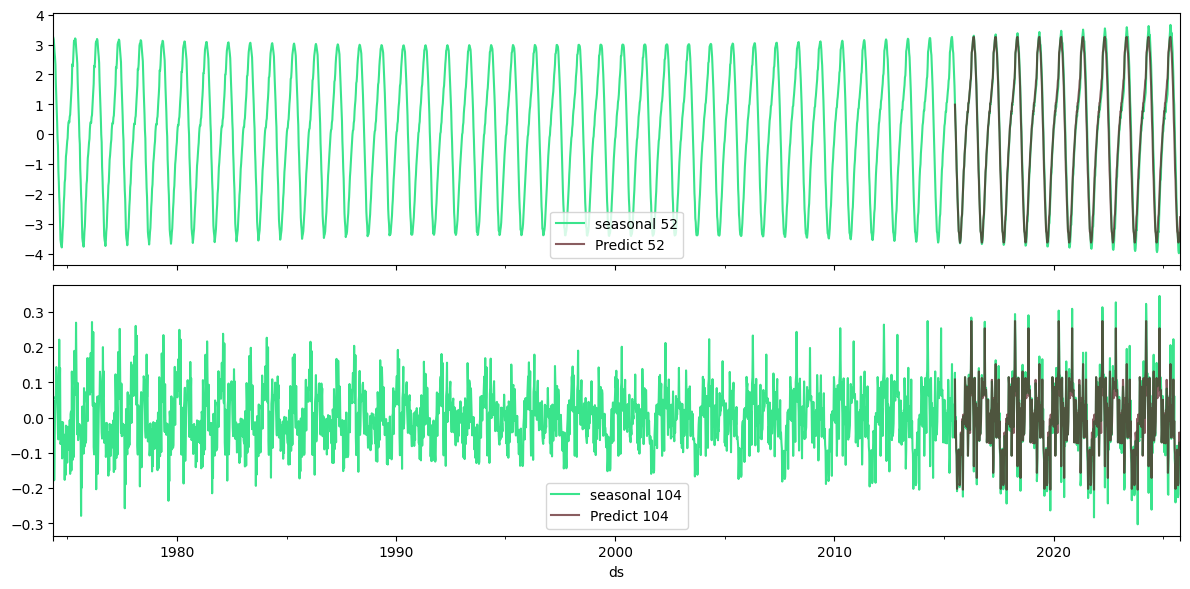

In [18]:
fig, (ax_seasonal_52, ax_seasonal_104) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True
)

fcst_52 = fcst_seasonal_52_df.set_index('ds')['SeasonalNaive']
fcst_104 = fcst_seasonal_104_df.set_index('ds')['SeasonalNaive']
seasonal_52 = decomposed_df['seasonal_52']
seasonal_104 = decomposed_df['seasonal_104']

seasonal_52.plot(ax=ax_seasonal_52, label='seasonal 52', color='#3AE48C')
fcst_52.plot(ax=ax_seasonal_52, label='Predict 52', color='#57191D', alpha=0.7)
ax_seasonal_52.legend()

seasonal_104.plot(ax=ax_seasonal_104, label='seasonal 104', color='#3AE48C')
fcst_104.plot(ax=ax_seasonal_104, label='Predict 104', color='#57191D', alpha=0.7)
ax_seasonal_104.legend()

plt.tight_layout()
plt.show()

In [19]:
co2_52_rmse, co2_52_mae, co2_52_mape = calculate(val_co2['seasonal_52'], fcst_52)
co2_104_rmse, co2_104_mae, co2_104_mape = calculate(val_co2['seasonal_104'], fcst_104)

df = pd.DataFrame({
    'model': ['Seasonal 52', 'Seasonal 104'],
    'rmse':  [co2_52_rmse,  co2_104_rmse],
    'mae':   [co2_52_mae,   co2_104_mae],
    'mape':  [co2_52_mape,  co2_104_mape],
}).set_index('model')

df

,rmse,mae,mape
model,,,
Seasonal 52,0.31289,0.243740,33.124523
Seasonal 104,0.02610,0.018483,71.833487


In [20]:
df.to_csv("../metrics/metrics_co2.csv", index=True)

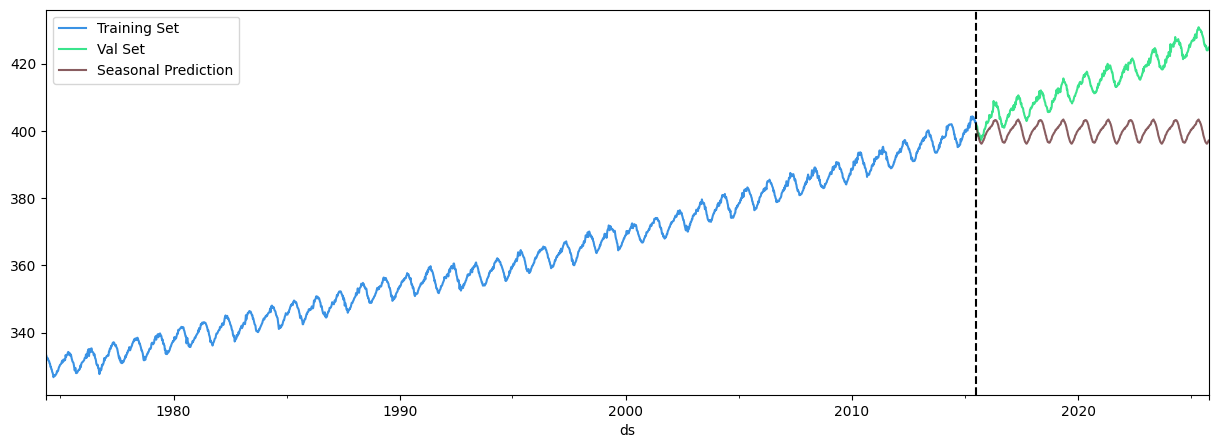

<Figure size 640x480 with 0 Axes>

In [21]:
seasonal_combo = (fcst_52 + fcst_104) + 400

train = df_co2.loc[df_co2.index < '2015-07-05']
val = df_co2.loc[df_co2.index >= '2015-07-05']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title="", color='#3A92E4')
val.plot(ax=ax, label='Val Set', color='#3AE48C')
seasonal_combo.plot(ax=ax, label='Seasonal Prediction', color='#57191D', alpha=0.7)
ax.axvline('2015-07-05', color='black', ls='--')
ax.legend(['Training Set', 'Val Set', 'Seasonal Prediction'])
plt.show()

plt.tight_layout()
plt.show()

## Hourly AEP

In [22]:
df_aep = pd.read_csv('../data/hourly_aep.csv')
df_aep['data_ind'] = df_aep['Date']
df_aep = df_aep.set_index('data_ind')
df_aep.index = pd.to_datetime(df_aep.index)

STL decomposition complete.


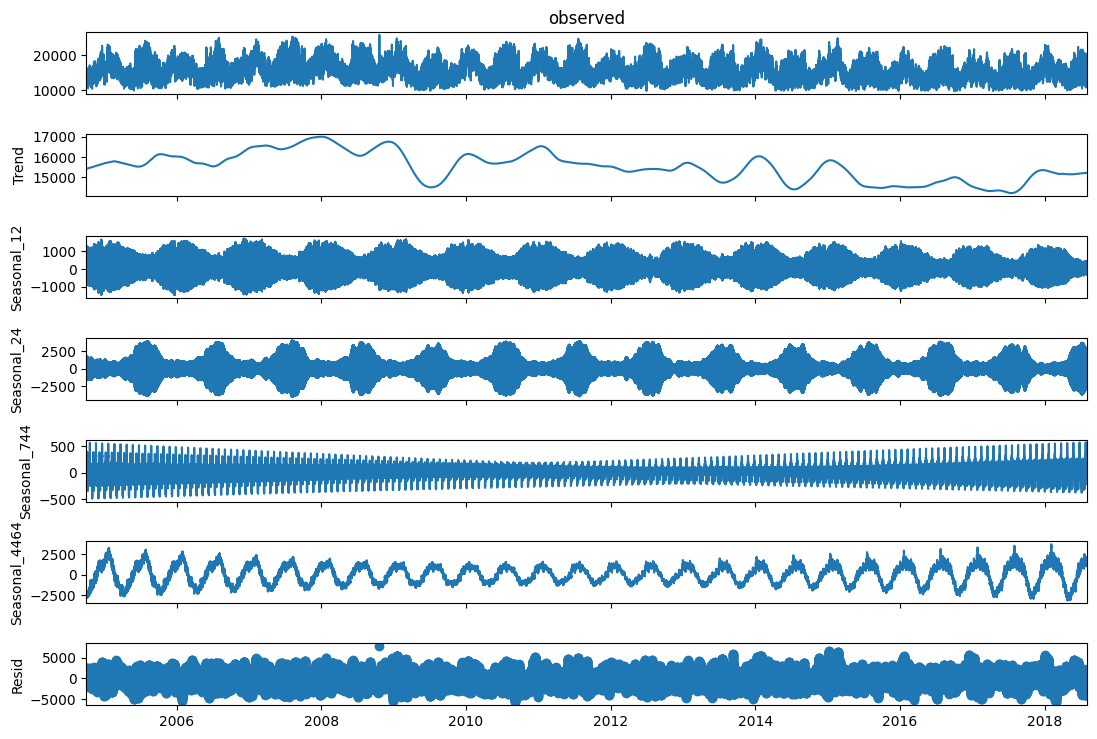

In [23]:
stl_aep = MSTL(df_aep['AEP_MW'], periods=[12, 24, 744, 4464], windows= [13, 25, 745, 4465])
res_stl = stl_aep.fit()

decomposed_df = df_aep.copy()
decomposed_df['trend'] = res_stl.trend
decomposed_df['seasonal_12'] = res_stl.seasonal['seasonal_12']
decomposed_df['seasonal_24'] = res_stl.seasonal['seasonal_24']
decomposed_df['seasonal_744'] = res_stl.seasonal['seasonal_744']
decomposed_df['seasonal_4464'] = res_stl.seasonal['seasonal_4464']
decomposed_df['resid'] = res_stl.resid
decomposed_df['y_adjusted'] = decomposed_df['trend'] + decomposed_df['resid']

print("STL decomposition complete.")

fig = res_stl.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
plt.show()

In [24]:
aep_decomposed = (
    decomposed_df[['Date', 'seasonal_12', 'seasonal_24', 'seasonal_744', 'seasonal_4464', 'resid', 'y_adjusted']]
    .assign(unique_id='AEP_MW')
    .rename(columns={
        'Date': 'ds',
        'y_adjusted': 'y'
    })
)

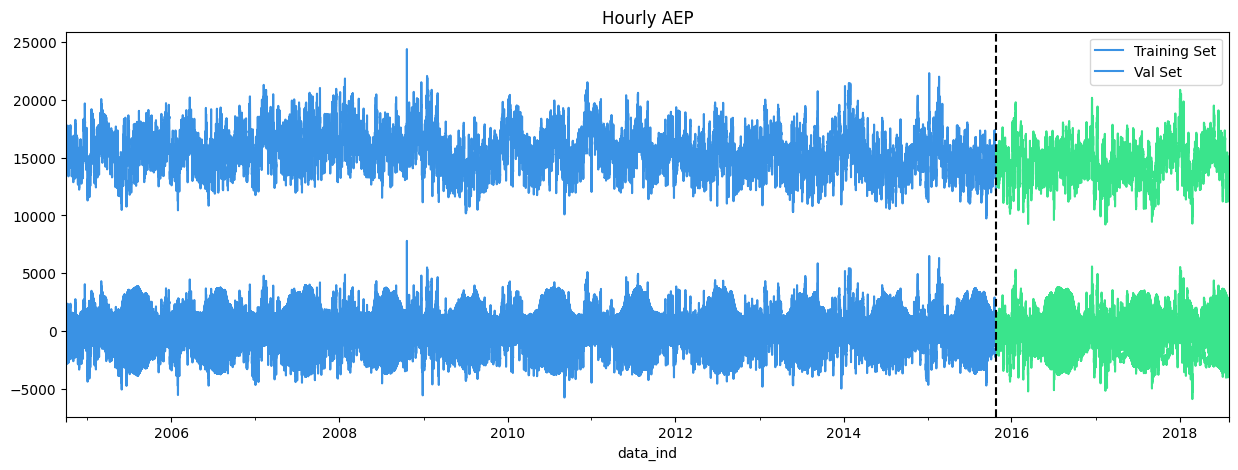

In [25]:
train_aep, val_aep = visualize_split(aep_decomposed, '2015-10-27 06:00:00', 'Hourly AEP')

###  Decomposition-Based Forecasting

Prediction of seasonal component.

In [26]:
forecast_horizon = len(val_aep)

sf_seasonal_12 = StatsForecast(models=[SeasonalNaive(season_length=12)], freq='h')
sf_seasonal_12.fit(train_aep[['ds', 'unique_id', 'seasonal_12']].rename(columns={'seasonal_12': 'y'}))
fcst_seasonal_12_df = sf_seasonal_12.predict(h=forecast_horizon)

sf_seasonal_24 = StatsForecast(models=[SeasonalNaive(season_length=24)], freq='h')
sf_seasonal_24.fit(train_aep[['ds', 'unique_id', 'seasonal_24']].rename(columns={'seasonal_24': 'y'}))
fcst_seasonal_24_df = sf_seasonal_24.predict(h=forecast_horizon)

sf_seasonal_744 = StatsForecast(models=[SeasonalNaive(season_length=744)], freq='h')
sf_seasonal_744.fit(train_aep[['ds', 'unique_id', 'seasonal_744']].rename(columns={'seasonal_744': 'y'}))
fcst_seasonal_744_df = sf_seasonal_744.predict(h=forecast_horizon)

sf_seasonal_4464 = StatsForecast(models=[SeasonalNaive(season_length=4464)], freq='h')
sf_seasonal_4464.fit(train_aep[['ds', 'unique_id', 'seasonal_4464']].rename(columns={'seasonal_4464': 'y'}))
fcst_seasonal_4464_df = sf_seasonal_4464.predict(h=forecast_horizon)

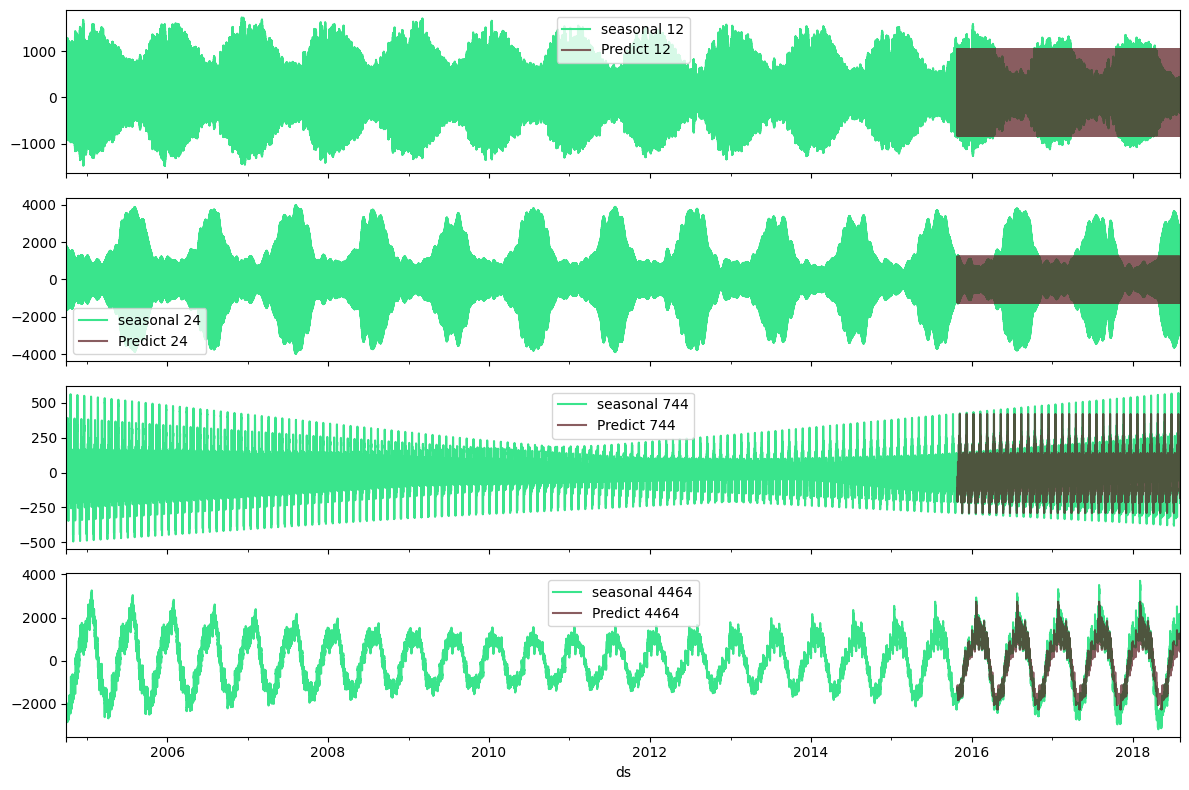

In [27]:
fig, (ax_seasonal_12, ax_seasonal_24, ax_seasonal_744, ax_seasonal_4464) = plt.subplots(
    4, 1, figsize=(12, 8), sharex=True
)

fcst_12 = fcst_seasonal_12_df.set_index('ds')['SeasonalNaive']
fcst_24 = fcst_seasonal_24_df.set_index('ds')['SeasonalNaive']
fcst_744 = fcst_seasonal_744_df.set_index('ds')['SeasonalNaive']
fcst_4464 = fcst_seasonal_4464_df.set_index('ds')['SeasonalNaive']
seasonal_12 = decomposed_df['seasonal_12']
seasonal_24 = decomposed_df['seasonal_24']
seasonal_744 = decomposed_df['seasonal_744']
seasonal_4464 = decomposed_df['seasonal_4464']

seasonal_12.plot(ax=ax_seasonal_12, label='seasonal 12', color='#3AE48C')
fcst_12.plot(ax=ax_seasonal_12, label='Predict 12', color='#57191D', alpha=0.7)
ax_seasonal_12.legend()

seasonal_24.plot(ax=ax_seasonal_24, label='seasonal 24', color='#3AE48C')
fcst_24.plot(ax=ax_seasonal_24, label='Predict 24', color='#57191D', alpha=0.7)
ax_seasonal_24.legend()

seasonal_744.plot(ax=ax_seasonal_744, label='seasonal 744', color='#3AE48C')
fcst_744.plot(ax=ax_seasonal_744, label='Predict 744', color='#57191D', alpha=0.7)
ax_seasonal_744.legend()

seasonal_4464.plot(ax=ax_seasonal_4464, label='seasonal 4464', color='#3AE48C')
fcst_4464.plot(ax=ax_seasonal_4464, label='Predict 4464', color='#57191D', alpha=0.7)
ax_seasonal_4464.legend()

plt.tight_layout()
plt.show()

In [28]:
aep12_rmse, aep12_mae, aep12_mape = calculate(val_aep['seasonal_12'],   fcst_12)
aep24_rmse, aep24_mae, aep24_mape = calculate(val_aep['seasonal_24'],   fcst_24)
aep744_rmse, aep744_mae, aep744_mape = calculate(val_aep['seasonal_744'], fcst_744)
aep4464_rmse, aep4464_mae, aep4464_mape = calculate(val_aep['seasonal_4464'], fcst_4464)

df = pd.DataFrame({
    'model': ['Seasonal 12', 'Seasonal 24', 'Seasonal 744', 'Seasonal 4464'],
    'rmse':  [aep12_rmse,    aep24_rmse,    aep744_rmse,    aep4464_rmse],
    'mae':   [aep12_mae,     aep24_mae,     aep744_mae,     aep4464_mae],
    'mape':  [aep12_mape,    aep24_mape,    aep744_mape,    aep4464_mape],
}).set_index('model')

df

,rmse,mae,mape
model,,,
Seasonal 12,316.352130,230.884742,414.907150
Seasonal 24,944.148515,658.421557,136.587328
Seasonal 744,33.767596,23.185635,115.722626
Seasonal 4464,377.378152,290.596682,73.467779


In [29]:
df.to_csv("../metrics/metrics_aep.csv", index=True)

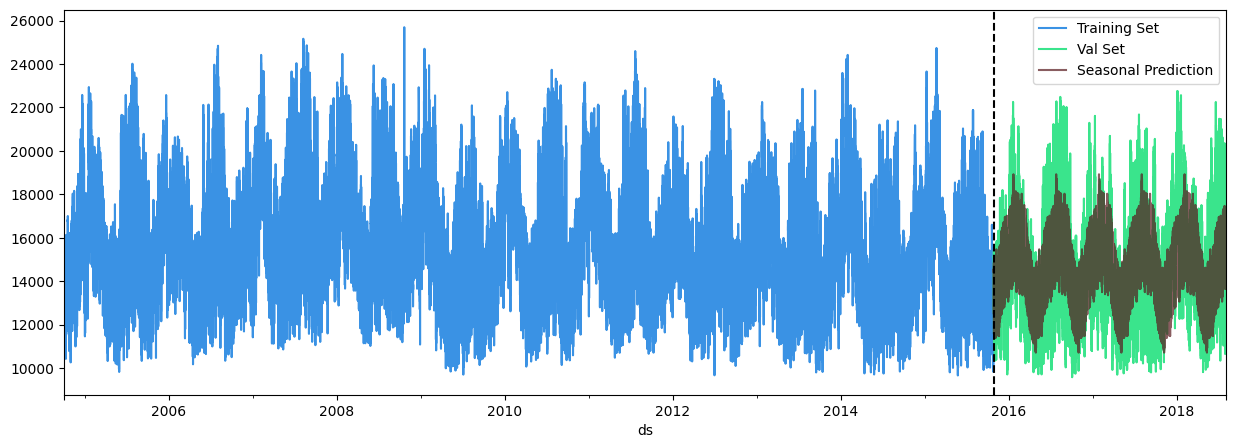

<Figure size 640x480 with 0 Axes>

In [30]:
seasonal_combo = (fcst_12 + fcst_24 + fcst_744 + fcst_4464) + 15000

train = df_aep.loc[df_aep.index < '2015-10-27 06:00:00']
val = df_aep.loc[df_aep.index >= '2015-10-27 06:00:00']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title="", color='#3A92E4')
val.plot(ax=ax, label='Val Set', color='#3AE48C')
seasonal_combo.plot(ax=ax, label='Seasonal Prediction', color='#57191D', alpha=0.7)
ax.axvline('2015-10-27 06:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Val Set', 'Seasonal Prediction'])
plt.show()

plt.tight_layout()
plt.show()